![Tests](https://github.com/jeromerg/filoc/workflows/Tests/badge.svg)

In [21]:
%%html
<style>
@import url('https://fonts.googleapis.com/css2?family=Dancing+Script:wght@400;700&display=swap');

.filoc { font-size:150%; font-family: 'Dancing Script', cursive; }

.highlight {
    background-color: lemonChiffon; 
    padding:0.5em;
    line-height:2em;
}
.highlight:before {
    content: "⮱";
    font-size: 2.2em;
    position: relative;
    bottom: -0.1em;
}
</style>

In [22]:
import itertools
import numpy as np
import pandas as pd
import torch
from   torch.autograd import Variable
import sklearn.datasets
import keras.utils

# <span class="filoc">filoc</span> in Machine Learning Workflow

During a machine learning workflow, <span class="filoc">filoc</span> is a simple yet powerful and scalable solution to:

- Prepare the hyperparameter settings
- Schedule and synchronize parallel simulations
- Analyse the simulation results

In comparison to existing solution like [neptune](https://neptune.ai/) and other hyperparameter tuning frameworks, it has the following advantages:

- No Server: You only need a network folder or amazon s3, google cloud storage, hadoop, azure data lake
- No Database: your files are the database
- Framework independent: <span class="filoc">filoc</span>  is not bound to any ML Framework

## Example 

In the following example, we will train a pytorch prediction model on the IRIS database and try to tune the hyperparameters

### Installing <span class="filoc">filoc</span> 

In [3]:
!pip install filoc

Defaulting to user installation because normal site-packages is not writeable


### Importing <span class="filoc">filoc</span> 

First, import the `filoc(...)` function. This is the most *pythonic* way to use *filoc*:

In [4]:
from filoc import filoc

<span class="highlight">The `filoc(...)` is a factory method that returns a `FilocContract` object, which is a kind of bi-directional adapter between a DataFrame and files defined in a structured manner.</span>

### Creating <span class="filoc">filoc</span>  instances

Now we prepare two filocs to read and write the following files:
- The hyperparameter files, which contain the hyperparameters definition for a each simulation
- The state files, used to synchronize the execution of the simulation and provide the execution state
- The result files, which contain the exported results for each given simulation and training epoch

In [5]:
hyperparams_loc = filoc('./temp/iris/sim={sim:d}/hyperparameters.json', writable=True)
state_loc       = filoc('./temp/iris/sim={sim:d}/state.json', writable=True)
result_loc      = filoc('./temp/iris/sim={sim:d}/epoch_{epoch:d}.json', writable=True)

<span class="highlight">The `filoc(...)` first argument describes the path where the files are stored. It contains format placeholders, which are part of the data that are read or written.
</span>

### Preparing the model to train
Say, we want to train the following two-layer feed-forward model with dropout to predict the iris class (3 classes) given the flower caracteristics (4 features):

In [6]:
class Model(torch.nn.Module):
    def __init__(self, layer1_size, layer2_size, dropout_prob):
        super(Model,self).__init__()
        self.l1      = torch.nn.Linear(4, layer1_size)
        self.l2      = torch.nn.Linear(layer1_size, layer2_size)
        self.l3      = torch.nn.Linear(layer2_size, 3)
        self.dropout = torch.nn.Dropout(p=dropout_prob)
    def forward(self, x):
        sigmoid = torch.nn.Sigmoid()
        relu    = torch.nn.ReLU()
        y       = relu(self.l1(x))
        y       = self.dropout(y)
        y       = relu(self.l2(y))
        y       = self.dropout(y)
        y       = sigmoid(self.l3(y))
        return y

This model has 3 hyperparameters: `layer1_size`, `layer2_size`, `dropout_prob`. We will perform a simple stochastic gradient descent with constant learning rate, so we get a fourth hyperparameter: `learning_rate`.

### Creating the simulation hyperparameter sets
We want to perform a basic grid search for the four hyperparameters `layer1_size`, `layer2_size`, `dropout_prob`, `learning_rate`. We build the grid manually:

In [14]:
# 2. generate hyperparameter set candidates
layer1_sizes   = [9, 27, 81]
layer2_sizes   = [9, 27, 81]
dropout_probs  = [0, 0.25, 0.5]
learning_rates = [0.01, 0.001]

sims_hyperparameters = []
for sim, (layer1_size, layer2_size, dropout_prob, learning_rate) in enumerate(itertools.product(layer1_sizes, layer2_sizes, dropout_probs, learning_rates)):
    sims_hyperparameters.append({
        'sim'           : sim, 
        'layer1_size'   : layer1_size, 
        'layer2_size'   : layer1_size, 
        'dropout_prob'  : dropout_prob, 
        'learning_rate' : learning_rate
    })
pd.DataFrame(sims_hyperparameters)

,sim,layer1_size,layer2_size,dropout_prob,learning_rate
0,0,9,9,0.00,0.010
1,1,9,9,0.00,0.001
2,2,9,9,0.25,0.010
3,3,9,9,0.25,0.001
4,4,9,9,0.50,0.010
5,5,9,9,0.50,0.001
6,6,9,9,0.00,0.010
7,7,9,9,0.00,0.001
8,8,9,9,0.25,0.010
9,9,9,9,0.25,0.001


### Saving the simulation hyperparameter sets

Now, we need to save each simulation hyperparameter set into a hyperparameter file:

In [15]:
hyperparams_loc.write_contents(sims_hyperparameters)

<span class="highlight">`FilocContract.write_contents(...)` created all the 53 hyperparameters files at once! It replaced the `sim` variable defined in the filoc path `./temp/iris/sim={sim:d}/hyperparameters.json`  by the `sim` value defined in the `sim_hyperparameters` list, then created the files and filled them with the remaining variables of the object.
</span>

Let's check the created files with the terminal `ls` command:

In [16]:
! ls ./temp/iris/*/*

'./temp/iris/sim=0/hyperparameters.json'
'./temp/iris/sim=10/hyperparameters.json'
'./temp/iris/sim=11/hyperparameters.json'
'./temp/iris/sim=12/hyperparameters.json'
'./temp/iris/sim=13/hyperparameters.json'
'./temp/iris/sim=14/hyperparameters.json'
'./temp/iris/sim=15/hyperparameters.json'
'./temp/iris/sim=16/hyperparameters.json'
'./temp/iris/sim=17/hyperparameters.json'
'./temp/iris/sim=18/hyperparameters.json'
'./temp/iris/sim=19/hyperparameters.json'
'./temp/iris/sim=1/hyperparameters.json'
'./temp/iris/sim=20/hyperparameters.json'
'./temp/iris/sim=21/hyperparameters.json'
'./temp/iris/sim=22/hyperparameters.json'
'./temp/iris/sim=23/hyperparameters.json'
'./temp/iris/sim=24/hyperparameters.json'
'./temp/iris/sim=25/hyperparameters.json'
'./temp/iris/sim=26/hyperparameters.json'
'./temp/iris/sim=27/hyperparameters.json'
'./temp/iris/sim=28/hyperparameters.json'
'./temp/iris/sim=29/hyperparameters.json'
'./temp/iris/sim=2/hyperparameters.json'
'./temp/iris/sim=30/hyperparameters.j

Let's check a single file:

In [17]:
! cat ./temp/iris/sim=23/hyperparameters.json

{
  "layer1_size": 27,
  "layer2_size": 27,
  "dropout_prob": 0.5,
  "learning_rate": 0.001
}

### Preparing the state file

We want to track the training state, in order to parallelize the simulation trainings and to keep the overview on which simulation has been performed, which not.
We need 4 states:

- `init` : simulation is ready to be executed
- `running` : simulation is currently executed
- `failed` : simulation has failed and stopped
- `succeeded` : simulation has ended properly

We prepare the state file for each simulation, in the same way as we previously prepared the hyperparameters:

In [20]:
sim_states = []
for hyp in sims_hyperparameters:
    sim_states.append({
        'sim'   : hyp['sim'], 
        'state' : 'init'
    })

with state_loc.lock():
    state_loc.write_contents(sim_states)

<span class="highlight">We locked the access to all state files within a `state_loc.lock()` with-block. It ensures that no other process currently read from nor write to the state files.
</span>

The locking implementation is relative simple and works only against other use of `state_loc.lock()` in other threads/processes/machines. But it is efficient enough to ensure the serialization of read and write accesses of concurrent sensitive files.

### Running the simulations

Now we are ready to perform the simulations!

In [48]:
# load training and validation dataset
iris    = sklearn.datasets.load_iris()
indexes = list(range(len(iris.data)))
np.random.shuffle(indexes)
all_X   = torch.from_numpy(iris.data).type(torch.DoubleTensor)
all_y   = torch.from_numpy(keras.utils.to_categorical(iris.target)).type(torch.DoubleTensor)
train_X = Variable(all_X[indexes[:100]])
train_y = Variable(all_y[indexes[:100]])
valid_X = Variable(all_X[indexes[100:150]])
valid_y = Variable(all_y[indexes[100:150]])

#print(f'train_X={train_X.shape}, valid_X={valid_X.shape}, train_y={train_y.shape}, valid_y={valid_y.shape}')

train_X=torch.Size([100, 4]), valid_X=torch.Size([50, 4]), train_y=torch.Size([100, 3]), valid_y=torch.Size([50, 3])


In [51]:


layer1_size   = 100
layer2_size   = 100
learning_rate = 0.01
dropout_prob  = 0.5

model    = Model(layer1_size, layer2_size, dropout_prob).double()

loss_fun = torch.nn.BCELoss(size_average=True)
opt      = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(20000):
    train_y_pred = model(train_X)
    train_loss   = loss_fun(train_y_pred, train_y)    
    train_acc    = (torch.argmax(train_y_pred, dim=1) == torch.argmax(train_y, dim=1)).sum().item() / len(train_y)
    opt.zero_grad()
    train_loss.backward()
    opt.step()

    with torch.no_grad():
        valid_y_pred = model(valid_X)
        valid_loss   = loss_fun(valid_y_pred, valid_y)    
        valid_acc    = (torch.argmax(valid_y_pred, dim=1) == torch.argmax(valid_y, dim=1)).sum().item() / len(valid_y)

    if epoch % 100 == 0:
        print({
            'train_loss' : train_loss.item(),
            'train_acc'  : train_acc,
            'valid_loss' : valid_loss.item(),
            'valid_acc'  : valid_acc,
        })

{'train_loss': 0.03168233444636589, 'train_acc': 0.98, 'valid_loss': 0.049163009214078436, 'valid_acc': 0.96}
{'train_loss': 0.03522447352570929, 'train_acc': 0.99, 'valid_loss': 0.06771883435554166, 'valid_acc': 0.98}
{'train_loss': 0.021743806819387975, 'train_acc': 0.99, 'valid_loss': 0.1412255768291411, 'valid_acc': 0.92}
{'train_loss': 0.039445649824771306, 'train_acc': 0.99, 'valid_loss': 0.1785807651839132, 'valid_acc': 0.96}
{'train_loss': 0.03744309580910632, 'train_acc': 0.98, 'valid_loss': 0.12659499807062835, 'valid_acc': 0.96}
{'train_loss': 0.027803571842636956, 'train_acc': 0.98, 'valid_loss': 0.11549584064673572, 'valid_acc': 0.94}
{'train_loss': 0.04293671748140396, 'train_acc': 0.97, 'valid_loss': 0.11885397725995524, 'valid_acc': 0.96}
{'train_loss': 0.017730040639064654, 'train_acc': 1.0, 'valid_loss': 0.12049402162170611, 'valid_acc': 0.94}
{'train_loss': 0.024299737818919174, 'train_acc': 1.0, 'valid_loss': 0.11415369453383738, 'valid_acc': 0.96}
{'train_loss': 0.

In [35]:
! ls ./temp/iris/candid=18/*

'./temp/iris/candid=18/epoch_0.json'
'./temp/iris/candid=18/epoch_10.json'
'./temp/iris/candid=18/epoch_11.json'
'./temp/iris/candid=18/epoch_12.json'
'./temp/iris/candid=18/epoch_13.json'
'./temp/iris/candid=18/epoch_14.json'
'./temp/iris/candid=18/epoch_15.json'
'./temp/iris/candid=18/epoch_16.json'
'./temp/iris/candid=18/epoch_17.json'
'./temp/iris/candid=18/epoch_18.json'
'./temp/iris/candid=18/epoch_19.json'
'./temp/iris/candid=18/epoch_1.json'
'./temp/iris/candid=18/epoch_2.json'
'./temp/iris/candid=18/epoch_3.json'
'./temp/iris/candid=18/epoch_4.json'
'./temp/iris/candid=18/epoch_5.json'
'./temp/iris/candid=18/epoch_6.json'
'./temp/iris/candid=18/epoch_7.json'
'./temp/iris/candid=18/epoch_8.json'
'./temp/iris/candid=18/epoch_9.json'
'./temp/iris/candid=18/hyperparameters.json'


In [36]:
! cat ./temp/iris/candid=18/epoch_19.json

{
  "score": 0.86
}

So we perform trainings for each simulation and stored the result for each epoch. Now we can start the analysis. First we need to join together the hyperparameters with the results. For that use again the `filoc` function as follows:

In [7]:
loc = filoc( {'hyp' : hyperparams_loc, 'res' : result_loc}, frontend='pandas', cache_locpath='temp/cache/iris/cache.bin')
df  = loc.read_contents()
df

,index.epoch,index.candid,hyp.kernel,hyp.C,hyp.degree,res.score
0,0,0,linear,0.01,1,0.88
1,0,1,linear,0.01,2,0.88
2,0,2,linear,0.01,3,0.88
3,0,3,linear,0.01,4,0.88
4,0,4,linear,0.01,5,0.88
...,...,...,...,...,...,...
2875,19,139,sigmoid,1000.00,2,0.86
2876,19,140,sigmoid,1000.00,3,0.86
2877,19,141,sigmoid,1000.00,4,0.86
2878,19,142,sigmoid,1000.00,5,0.86


In [38]:
df.describe()

,index.epoch,index.candid,hyp.C,hyp.degree,res.score
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000
mean,9.500000,71.500000,185.185000,3.500000,0.858056
std,5.767283,41.575436,366.201103,1.708122,0.042975
min,0.000000,0.000000,0.010000,1.000000,0.640000
25%,4.750000,35.750000,0.100000,2.000000,0.860000
50%,9.500000,71.500000,5.500000,3.500000,0.860000
75%,14.250000,107.250000,100.000000,5.000000,0.880000
max,19.000000,143.000000,1000.000000,6.000000,0.920000


<AxesSubplot:xlabel='index.epoch'>

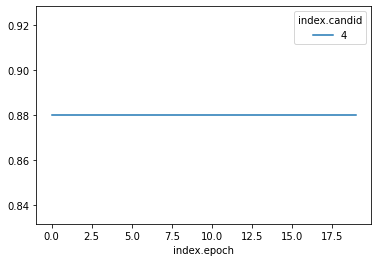

In [45]:
df[df['index.candid'] == 4].pivot(index='index.epoch', columns='index.candid', values='res.score').plot()


TODO
- Readme Doc
- API Doc 
- File locking
- Unit Test 
    - Multiloc with different aggregation layers (snowflake)
    - File locking
- Dev: Logging of edited files
- Dev: File watcher
- Dev: Excel File watcher / binder